In [17]:
import numpy as np
import torch, scipy

torch.set_default_dtype(torch.float32)
torch.manual_seed(0)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [18]:
S = 2**16
RN = 32
Channel = 1
TS = 300

In [19]:
import os, pickle

with open(os.path.join(os.path.abspath('.'), 'KnownData', 'ParaSam' + '.pickle'), 'rb') as file:
    sam, Tsam = pickle.load(file)
sam = torch.from_numpy(sam).float()
Tsam = torch.from_numpy(Tsam).float() 

In [20]:
import picnn

Forward_Model = picnn.Forward_Model

In [21]:
import pickle, os, math
from tqdm.notebook import trange

with open(os.path.join(os.path.abspath('.'), 'KnownData', 'ParaSam' + '.pickle'), 'rb') as file:
    sam, Tsam = pickle.load(file)

with open(os.path.join(os.path.abspath('.'), 'KnownData', 'UTSam' + '.pickle'), 'rb') as file:
    u_Tsam, obs_Tsam = pickle.load(file)
'''
sam = torch.from_numpy(sam).float()
sam_mean = torch.mean(sam, dim=0).squeeze()
sam_v = torch.var(sam.reshape((sam.shape[0], -1)), dim=0).squeeze()+0.1
with open(os.path.join(os.path.abspath('.'), 'KnownData', 'KIV_pri' + '.pickle'), 'wb') as file:
    pickle.dump((sam_mean, sam_v), file)
'''

with open(os.path.join(os.path.abspath('.'), 'KnownData', 'KIV_pri' + '.pickle'), 'rb') as file:
    pri_mean, pri_cov = pickle.load(file)
pri_cov += 0.1
#pri_cov = torch.diag(pri_cov)
s0 = pri_mean.flatten()

Tsam = torch.from_numpy(Tsam).float() 
obs_Tsam = torch.from_numpy(obs_Tsam).float() * 100

noise_level = [0.02, 0.04, 0.08, 0.16, 0.32, 0.64]
noise_fw = {'sem': 0.04, 'sup': 0.05}
obsnl = [0,3,6,9,18]
mode, noise_l, obn = 'sem', 5, 4
obsn = obsnl[obn]
obs_data = obs_Tsam + torch.randn(obs_Tsam.shape) * noise_level[noise_l] 
#obs_data = obs_data.to(device)
obs_d = obs_data[obsn,...].flatten()
Nen = 4096
batch_size = 64
N_batch = math.ceil(Nen/batch_size)
N_iter = 100
plot_time = {0,1,3,5,8,11,15,19,24,29,39,49,69,89,119,149,179,219,249,299,349,399,449,499}
beta0, alpha0 = 2.0, 0.2
gam1, gam2 = 0.8, 0.9

In [22]:

from IPython.display import clear_output

sigm = noise_level[noise_l]**2 + noise_fw[mode]**2
if mode == 'sem':
    Forward_Model.load_para()
elif mode == 'sup':
    Forward_Model.load_para_sup
Forward_Model.network.eval()
clear_output()

In [23]:
C0 = torch.diag(pri_cov)
noise_cov = sigm*torch.ones_like(obs_d)
Gamma_pri = torch.cat((pri_cov, noise_cov), dim=0)
para_pri = torch.cat((s0, obs_d), dim=0)
Gamma_pri = torch.diag(Gamma_pri)
Gamma_pri1 = torch.cat((pri_cov*0.25, noise_cov), dim=0)
Gamma_pri1 = torch.diag(Gamma_pri1)

tensor(67.2837)


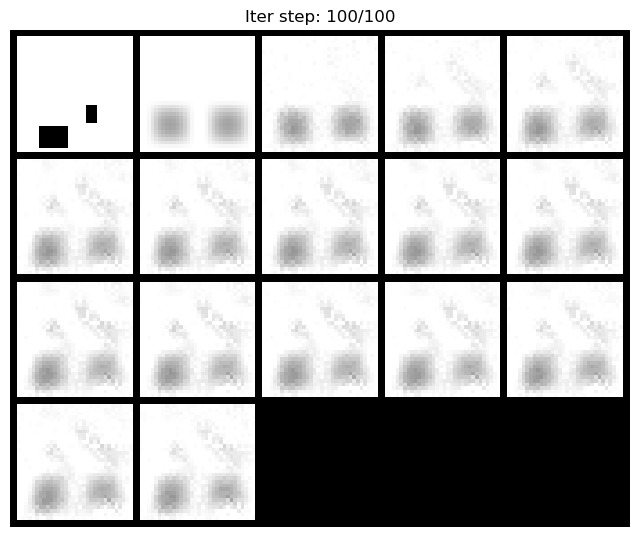

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


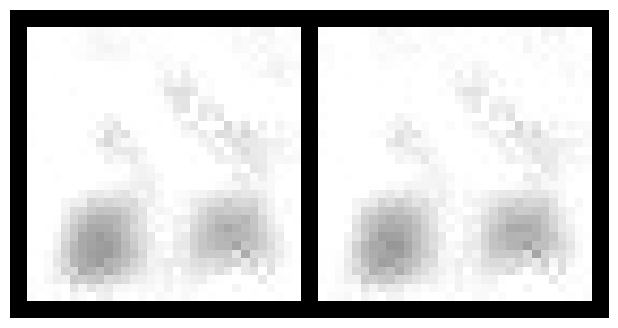

In [24]:

from torch.distributions import multivariate_normal
from torchvision.utils import make_grid
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

with torch.no_grad():
    mvn = multivariate_normal.MultivariateNormal(s0, C0)
    s_batch = mvn.sample_n(Nen)
    s_get = s_batch.mean(dim=0).flatten()
    s_batch = s_batch - s_get[None,...] + s0[None,...]
    s_get = s_batch.mean(dim=0).flatten()
    hgs = torch.zeros((Nen, obs_d.shape[0]))
    EKI_result = torch.cat((Tsam[obsn:(obsn+1),...], s_get.reshape((1,1,RN,RN))), dim=0)
    EKI_grid = make_grid(1-EKI_result, nrow=5)
    fig = plt.figure(figsize=(8,40))
    ax = fig.add_subplot(1,1,1)
    ax.axis('off')
    ax.imshow(EKI_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
    ax.set_title('Iter step: %d/%d'%(0, N_iter), fontsize=12)
    # plt.savefig('EKI_res.eps', format='eps')
    display(fig)
    clear_output(wait=True)
    plt.pause(0.5)
    # tqdm_iter = trange(N_iter)
    for iter in range(N_iter):
        betait = beta0*np.power((iter+1), -gam1)
        alphait = alpha0*np.sqrt(betait)*np.power((iter+1), gam2-1)
        for i in range(N_batch):
            x = s_batch[i*batch_size:min((i+1)*batch_size, Nen),...].to(device)
            x = x.reshape((x.shape[0],1,RN,RN))
            hgs[i*batch_size:min((i+1)*batch_size, Nen),...] = Forward_Model.obs(Forward_Model.network(x)).reshape(x.shape[0],-1).cpu()
        obs = torch.cat((s_batch, hgs), dim=1)
        dobs = para_pri[None,...] - obs 
        mvn = multivariate_normal.MultivariateNormal(torch.zeros_like(para_pri), Gamma_pri1)
        dobs += mvn.sample_n(Nen)
        obs_nor = obs - obs.mean(dim=0).flatten()[None,...]
        s_nor = s_batch - s_batch.mean(dim=0).flatten()[None,...]
        Pit = torch.matmul(obs_nor.t(), obs_nor) / Nen
        Qit = torch.matmul(s_nor.t(), obs_nor) / Nen
        Kit = torch.linalg.solve(Pit+betait*Gamma_pri, Qit.t())
        mvn = multivariate_normal.MultivariateNormal(torch.zeros_like(s0), C0)
        s_batch += torch.matmul(dobs, Kit) + alphait*mvn.sample_n(Nen)*0.5
        s_get = s_batch.mean(axis=0).flatten()
        if iter in plot_time or iter == (N_iter-1):
            lss = torch.square(obs_d - Forward_Model.obs(Forward_Model.network(s_get.reshape(1,1,RN,RN).to(device))).flatten().cpu()).sum()
            EKI_result = torch.cat((EKI_result,s_get.reshape((1,1,RN,RN))), dim=0)
            EKI_grid = make_grid(1-EKI_result, nrow=5)
            fig = plt.figure(figsize=(8,40))
            ax = fig.add_subplot(1,1,1)
            ax.axis('off')
            ax.imshow(EKI_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
            ax.set_title('Iter step: %d/%d'%(iter+1, N_iter), fontsize=12)
            # plt.savefig('EKI_res.eps', format='eps')
            display(fig)
            clear_output(wait=True)
            print(lss)
            plt.pause(0.5)
            if iter == 49:
                resave = s_get.reshape((1,1,RN,RN))
            elif iter == 99:
                resave2 = s_get.reshape((1,1,RN,RN))
    samp = torch.cat((resave, resave2), dim=0)
    sample_grid = make_grid(1-samp, nrow=3)
    plt.figure(figsize=(8,4))
    plt.axis('off')
    plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
    plt.savefig(os.path.join(os.path.abspath('.'), 'figs', 'post', 'post_eki_%d_%d.jpg'%(noise_l, obsn)), dpi=600, format='jpg')
    plt.show()
    plt.close()